In [1]:
import os
import random
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset

from preparing import prepare_dataset, prepare_dataset_mode
from preprocessing import preprocess_retina_imgs
from extract_patches import get_data_training, get_data_testing

---
## temp

In [2]:
from matplotlib import pyplot as plt

try:
    data_dir = "~/deeplearning/datasets/DRIVE/archive/DRIVE_datasets_training_testing"
    patches_imgs_train = np.load(f"{data_dir}/tr_patches_64x64_X.npy")
    patches_masks_train = np.load(f"{data_dir}/tr_patches_64x64_M.npy")

    N = 5
    fig, axs = plt.subplots(N,4, figsize=(3*4, 3*N))
    for i in range(0, N):
        axs[i, 0].imshow(np.moveaxis(patches_imgs_train[2*i],0,-1))
        axs[i, 0].axis('off')
        axs[i, 1].imshow(patches_masks_train[2*i, 0])
        axs[i, 1].axis('off')
        axs[i, 2].imshow(np.moveaxis(patches_imgs_train[2*+1],0,-1))
        axs[i, 2].axis('off')
        axs[i, 3].imshow(patches_masks_train[2*i+1, 0])
        axs[i, 3].axis('off')

    axs[0,0].set_title("Image")
    axs[0,1].set_title("Mask")
    axs[0,2].set_title("Image")
    axs[0,3].set_title("Mask")

    plt.show()
except:
    pass

## Dataset

In [3]:
class RetinaDriveDataset(Dataset):
    def __init__(
        self,
        processed_data_dir = "/home/staff/azad/deeplearning/datasets/DRIVE/archive/DRIVE_datasets_training_testing",
        original_base_dir = '/home/staff/azad/deeplearning/datasets/DRIVE',
        dataset_files_prefix = "DRIVE_dataset",
        mode = 'train',
        
        height = 584,
        width = 565,
        patch_height = 64,
        patch_width = 64,
        
        force_to_reprocess = False,
        data_process_verbose = False,
        transform=None,
        **kwargs
    ):
        
        self.processed_data_dir = processed_data_dir
        self.original_base_dir = original_base_dir
        self.dataset_files_prefix = dataset_files_prefix
        self.mode = mode
        self.channels = 3
        self.height = height
        self.width = width
        self.patch_height = patch_height
        self.patch_width = patch_width
        self.force_to_reprocess = force_to_reprocess
        self.data_process_verbose = data_process_verbose
        self.transform = transform
        
        if self.mode in ["train", "validation"]:
            self.tr_vl_split = kwargs['tr_vl_split'] if 'tr_vl_split' in kwargs.keys() else 0.75
            self.num_subimgs = kwargs['num_subimgs'] if 'num_subimgs' in kwargs.keys() else 200000
            self.imgs_file_name  = f"{self.dataset_files_prefix}_imgs_train"
            self.msks_file_name  = f"{self.dataset_files_prefix}_msks_train"
            self.bmsks_file_name = f"{self.dataset_files_prefix}_bmsks_train" # border-masks
        elif self.mode == "test":
            self.num_imgs_to_test = kwargs['num_imgs_to_test'] if 'num_imgs_to_test' in kwargs.keys() else 20
            self.imgs_file_name  = f"{self.dataset_files_prefix}_imgs_test"
            self.msks_file_name  = f"{self.dataset_files_prefix}_msks_test"
            self.bmsks_file_name = f"{self.dataset_files_prefix}_bmsks_test" # border-masks
        
        self.__prepare_dataset()
        self.__load_dataset()
        print(f"{self.mode}-dataset finished and ready to use\n")
        
        
    def __len__(self):
        return len(self.imgs)

    
    def __getitem__(self, idx):
        image = self.imgs[idx, 0]
        mask  = self.msks[idx, 0]
        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
    def __load_dataset(self):
        ph = self.patch_height
        pw = self.patch_width
        fd = self.processed_data_dir
        tmp = {'train': 'tr', 'test': 'te', 'validation': 'vl'}
        
        print(f"loading {self.mode} patches...")
        self.imgs = np.load(f"{self.processed_data_dir}/{tmp[self.mode]}_patches_{ph}x{pw}_X.npy")
        self.msks = np.load(f"{self.processed_data_dir}/{tmp[self.mode]}_patches_{ph}x{pw}_M.npy")    
        self.imgs = torch.Tensor(self.imgs)
        self.msks = torch.Tensor(self.msks)
        

    def __is_data_already_exist(self):
        ph = self.patch_height
        pw = self.patch_width
        fd = self.processed_data_dir
        tmp = {'train': 'tr', 'test': 'te', 'validation': 'vl'}
        
        file_exists_X = os.path.exists(f"{fd}/{tmp[self.mode]}_patches_{ph}x{pw}_X.npy")
        file_exists_M = os.path.exists(f"{fd}/{tmp[self.mode]}_patches_{ph}x{pw}_M.npy")
        
        if file_exists_X and file_exists_M:
            return True
        return False
                                       

    def __prepare_dataset(self):
        
        if self.__is_data_already_exist():
            print(f"processed ({self.mode})-data already exists.")
            if not self.force_to_reprocess:
                return
            print("forced to reprocess...")
        else:
            print(f"processed ({self.mode})-data not found!")
            
        ph = self.patch_height
        pw = self.patch_width
        
        print('\npreparing dataset...')
        prepare_dataset_mode(
            self.processed_data_dir, 
            self.original_base_dir,
            self.height, self.width, self.channels,
            self.imgs_file_name, self.msks_file_name, self.bmsks_file_name, 
            verbose = self.data_process_verbose
        )

        print('\nextracting patches (preprocessing are also performing)...')
        if self.mode in ['train', 'validation']:
            patches_imgs, patches_msks = get_data_training(
                DRIVE_train_imgs_original_hdf_fp = f'{self.processed_data_dir}/{self.imgs_file_name}.hdf5',
                DRIVE_train_groudTruth_hdf_fp = f'{self.processed_data_dir}/{self.msks_file_name}.hdf5', #masks
                patch_height = ph, patch_width = pw,
                N_subimgs = self.num_subimgs,
                inside_FOV = 'True', #select the patches only inside the FOV  (default == True),
                verbose = self.data_process_verbose
            )

            tr_vl_index = int(len(patches_imgs) * self.tr_vl_split)
            print('\nsaving extracted patches...')
            # save training patches
            np.save(f'{self.processed_data_dir}/tr_patches_{ph}x{pw}_X', patches_imgs[:tr_vl_index])
            np.save(f'{self.processed_data_dir}/tr_patches_{ph}x{pw}_M', patches_msks[:tr_vl_index])
            # save validation patches
            np.save(f'{self.processed_data_dir}/vl_patches_{ph}x{pw}_X', patches_imgs[tr_vl_index:])
            np.save(f'{self.processed_data_dir}/vl_patches_{ph}x{pw}_M', patches_msks[tr_vl_index:])
        
        else: # test
            patches_imgs, patches_msks = get_data_testing(
                DRIVE_test_imgs_original_hdf_fp = f'{self.processed_data_dir}/{self.imgs_file_name}.hdf5',
                DRIVE_test_groudTruth_hdf_fp = f'{self.processed_data_dir}/{self.msks_file_name}.hdf5', #masks
                Imgs_to_test = self.num_imgs_to_test,
                patch_height = ph, patch_width = pw,
                verbose = self.data_process_verbose
            )

            print('\nsaving extracted patches...')
            # save test patches
            np.save(f'{self.processed_data_dir}/te_patches_{ph}x{pw}_X', patches_imgs)
            np.save(f'{self.processed_data_dir}/te_patches_{ph}x{pw}_M', patches_msks)

## Test

processed (train)-data already exists.
loading train patches...
train-dataset finished and ready to use

The length of train set is: 150000
processed (test)-data already exists.
loading test patches...
test-dataset finished and ready to use

The length of test set is: 1800

processed (validation)-data already exists.
loading validation patches...
validation-dataset finished and ready to use

The length of validation set is: 50000

Training


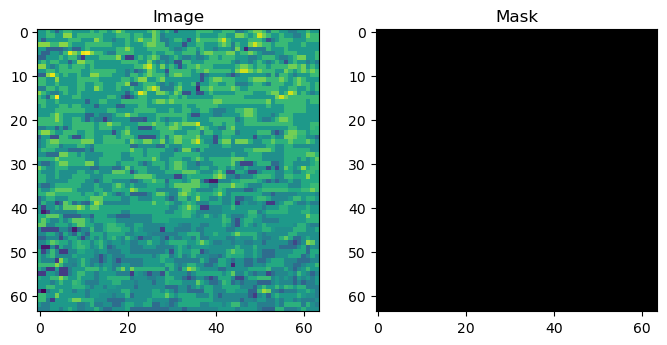

Validation


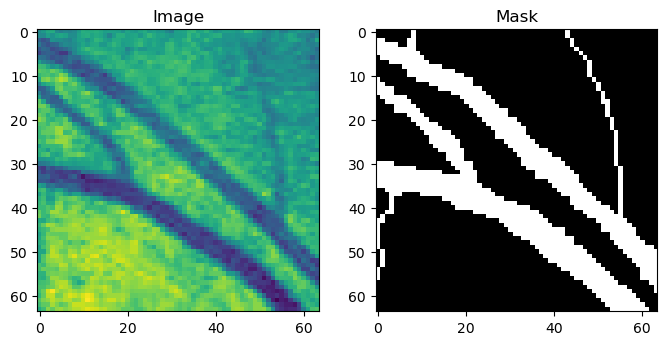

Test


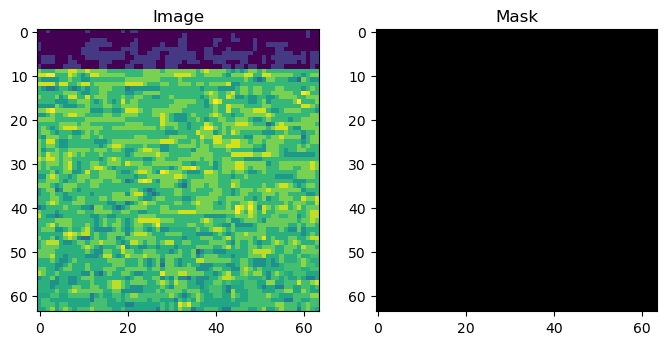

In [7]:
import sys
sys.path.append('../..')
from extra import show_sbs
from torch.utils.data import DataLoader, Subset
from torchvision import transforms



# # ------------------- params --------------------
INPUT_SIZE = 64
processed_data_dir = "/home/staff/azad/deeplearning/datasets/DRIVE/archive/DRIVE_datasets_training_testing"
original_base_dir = '/home/staff/azad/deeplearning/datasets/DRIVE'
dataset_files_prefix = "DRIVE_dataset"
    
TR_BATCH_SIZE = 8
TR_DL_SHUFFLE = True
TR_DL_WORKER = 1

VL_BATCH_SIZE = 12
VL_DL_SHUFFLE = False
VL_DL_WORKER = 1

TE_BATCH_SIZE = 12
TE_DL_SHUFFLE = False
TE_DL_WORKER = 1
# # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# # ----------------- transform ------------------
# transform for image
img_transform = transforms.Compose([
    transforms.Resize(
        size=[INPUT_SIZE, INPUT_SIZE], 
        interpolation=transforms.functional.InterpolationMode.BILINEAR
    ),
])
# transform for mask
msk_transform = transforms.Compose([
    transforms.Resize(
        size=[INPUT_SIZE, INPUT_SIZE], 
        interpolation=transforms.functional.InterpolationMode.NEAREST
    ),
])
# # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# # ----------------- dataset --------------------
# preparing training dataset
tr_dataset = RetinaDriveDataset(
    processed_data_dir = processed_data_dir,
    original_base_dir = original_base_dir,
    dataset_files_prefix = dataset_files_prefix,
    mode = 'train',

    height = 584,
    width = 565,
    patch_height = INPUT_SIZE,
    patch_width = INPUT_SIZE,

    force_to_reprocess = False,
    data_process_verbose = True,
    transform=None,
    
    tr_vl_split = 0.75,
    n_subimages = 200000
)
print("The length of train set is: {}".format(len(tr_dataset)))

# preparing test dataset
te_dataset = RetinaDriveDataset(
    processed_data_dir = processed_data_dir,
    original_base_dir = original_base_dir,
    dataset_files_prefix = dataset_files_prefix,
    mode = 'test',
    
    height = 584,
    width = 565,
    
    force_to_reprocess = False,
    data_process_verbose = True,
    num_imgs_to_test = 20
)
print(f"The length of test set is: {len(te_dataset)}\n")

# preparing validation dataset
vl_dataset = RetinaDriveDataset(
    processed_data_dir = processed_data_dir,
    original_base_dir = original_base_dir,
    dataset_files_prefix = dataset_files_prefix,
    mode = 'validation',
    force_to_reprocess = False,
    data_process_verbose = True,
)
print(f"The length of validation set is: {len(vl_dataset)}\n")




import random
def worker_init_fn(worker_id):
    random.seed(2022)


# # prepare train dataloader
tr_loader = DataLoader(
    tr_dataset, 
    batch_size=TR_BATCH_SIZE, 
    shuffle=TR_DL_SHUFFLE, 
    num_workers=TR_DL_WORKER,
    pin_memory=True,
    worker_init_fn=worker_init_fn
)

# prepare validation dataloader
vl_loader = DataLoader(
    vl_dataset, 
    batch_size=VL_BATCH_SIZE, 
    shuffle=VL_DL_SHUFFLE, 
    num_workers=VL_DL_WORKER,
    pin_memory=True
)

# prepare test dataloader
te_loader = DataLoader(
    te_dataset, 
    batch_size=TE_BATCH_SIZE, 
    shuffle=TE_DL_SHUFFLE, 
    num_workers=TE_DL_WORKER,
    pin_memory=True
)

# -------------- test -----------------
# test and visualize the input data
for batch in tr_loader:
    print("Training")
    img = batch['image']
    msk = batch['mask']
    show_sbs(img[0], msk[0])
    break
    
for batch in vl_loader:
    print("Validation")
    img = batch['image']
    msk = batch['mask']
    show_sbs(img[0], msk[0])
    break

for batch in te_loader:
    print("Test")
    img = batch['image']
    msk = batch['mask']
    show_sbs(img[0], msk[0])
    break
